In [1]:
import jax
import jax.numpy as jnp
from jax.random import multivariate_normal as jmn
import matplotlib.pyplot as plt

key = jax.random.PRNGKey(0)

In [2]:
@jax.jit
def state_transition(state, control, dt, L):
    """State transition function for a bycicle model."""
    x, y, theta, v = state
    a, delta = control

    # Bicycle model kinematics
    x_next = x + v * jnp.cos(theta) * dt
    y_next = y + v * jnp.sin(theta) * dt
    theta_next = theta + v * jnp.tan(delta) / L * dt
    v_next = v + a * dt

    return jnp.array([x_next, y_next, theta_next, v_next])


@jax.jit
def measurement_function(state):
    """Measurement function. Returns the x and y position but not the angle and velocity."""
    return state[:2]

In [3]:
# Parameters and initial conditions
dt = 0.1
L = 2.5

smean = jnp.zeros(4)
covQ = jnp.diag(jnp.array([0.01, 0.01, 0.01, 0.1]))  # Process noise
omean = jnp.zeros(2)
covR = jnp.diag(jnp.array([0.1, 0.1]))  # Measurement noise

state_0 = jnp.array([0.0, 0.0, 0.0, 0.0])
n_steps = 100

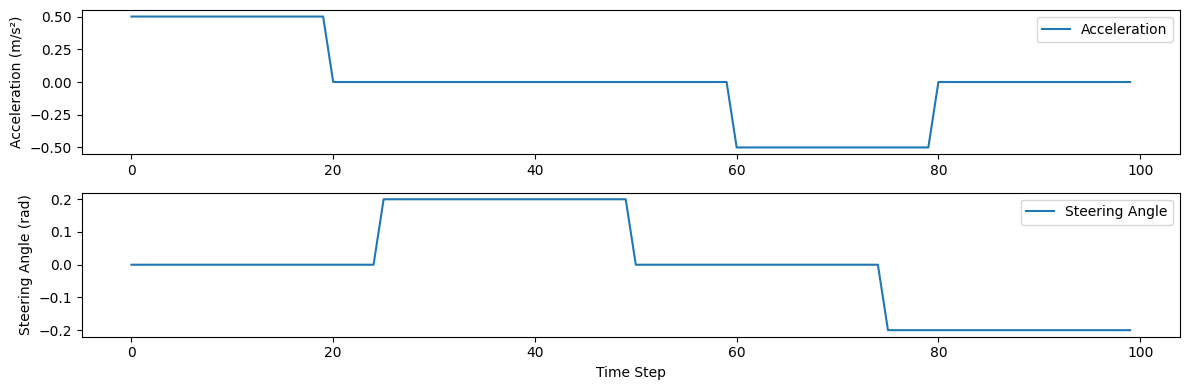

In [4]:
# Generate synthetic control inputs
controls = []

# Acceleration input (accelerate, maintain, decelerate, then maintain)
accel_profile = [0.5] * 20 + [0.0] * 40 + [-0.5] * 20 + [0.0] * 20

# Steering input (straight, right turn, straight, left turn, straight)
steer_profile = [0.0] * 25 + [0.2] * 25 + [0.0] * 25 + [-0.2] * 25

for accel, steer in zip(accel_profile, steer_profile):
    controls.append(jnp.array([accel, steer]))

controls = jnp.stack(controls)

# Plot the control inputs
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
plt.plot(controls[:, 0], label="Acceleration")
plt.ylabel("Acceleration (m/s²)")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(controls[:, 1], label="Steering Angle")
plt.ylabel("Steering Angle (rad)")
plt.xlabel("Time Step")
plt.legend()
plt.tight_layout()
plt.show()

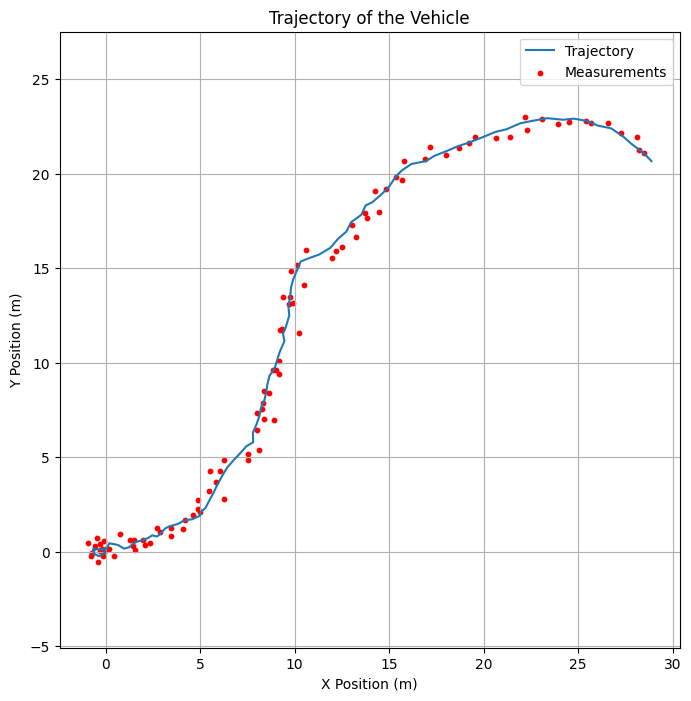

In [5]:
# Generate trajectory with noise and constrol
states = [state_0]
        
for i in range(1, controls.shape[0]):
    key, subkey = jax.random.split(key)
    w = jmn(subkey, smean, covQ)
    next_state = state_transition(states[i-1], controls[i], dt, L) + w
    states.append(next_state)

states = jnp.stack(states)

# Generate noisy measurements
key, subkey = jax.random.split(key)
v = jmn(subkey, omean, covR, shape=(states.shape[0],))
measurements = states[:, :2] + v

# Plot the trajectory
plt.figure(figsize=(8, 8))
plt.plot(states[:, 0], states[:, 1], label="Trajectory")

# Plot the measurements
plt.scatter(measurements[:, 0], measurements[:, 1], color='red', label="Measurements", s=10)

plt.title("Trajectory of the Vehicle")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()

In [6]:
def extended_kalman_filter(measurements, controls, x0, P0):
    """EKF with JAX"""
    
    # Use JAX automatic differentiation to compute Jacobians
    state_jacobian = jax.jit(jax.jacfwd(lambda s, c: state_transition(s, c, dt, L), argnums=0))
    measurement_jacobian = jax.jit(jax.jacfwd(measurement_function))
    
    @jax.jit
    def ekf_step(carry, inputs):
        """Single EKF step combining prediction and update"""
        x, P = carry
        measurement, control = inputs
        
        # Prediction step
        x_pred = state_transition(x, control, dt, L)
        F = state_jacobian(x, control)

        P_pred = F @ P @ F.T + covQ
        
        # Update step
        H = measurement_jacobian(x_pred)
        y_pred = measurement_function(x_pred)
        innovation = measurement - y_pred
        S = H @ P_pred @ H.T + covR
        
        # Compute the Kalman gain and update the state and covariance
        K = P_pred @ H.T @ jnp.linalg.solve(S, jnp.eye(S.shape[0]))
        x_new = x_pred + K @ innovation
        P_new = (jnp.eye(P_pred.shape[0]) - K @ H) @ P_pred
        
        # Ensure covariance stays symmetric
        P_new = (P_new + P_new.T) / 2
        
        return (x_new, P_new), (x_new, P_new)
    

    # Combine measurements and controls for scan
    scan_inputs = (measurements, controls)
    
    # Use scan to iterate through measurements and controls
    _, (xs, Ps) = jax.lax.scan(ekf_step, (x0, P0), scan_inputs)
    
    # Prepend initial state and covariance
    xs = jnp.vstack([x0[None, :], xs])
    Ps = jnp.vstack([P0[None, :, :], Ps])
    
    return xs, Ps

P0 = jnp.eye(4) * 0.1
preds, Ps = extended_kalman_filter(measurements, controls, state_0, P0)

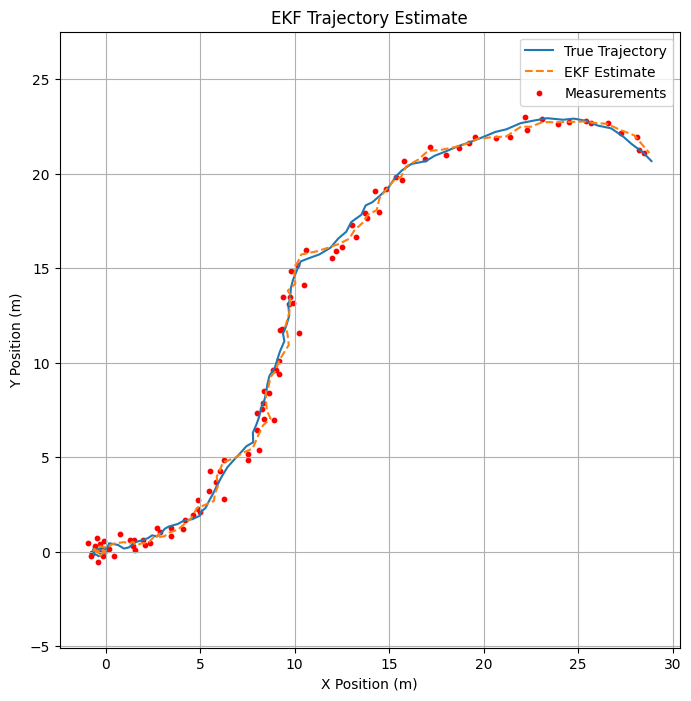

In [7]:
# Plot the trajectory with EKF estimates
plt.figure(figsize=(8, 8))
plt.plot(states[:, 0], states[:, 1], label="True Trajectory")
plt.plot(preds[:, 0], preds[:, 1], label="EKF Estimate", linestyle='--')
plt.scatter(measurements[:, 0], measurements[:, 1], color='red', label="Measurements", s=10)
plt.title("EKF Trajectory Estimate")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()